## Question 1: Getting Familiar With the Dataset

Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

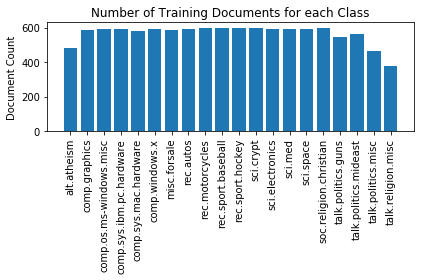

In [0]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

ng_train = fetch_20newsgroups(subset='train')
targets, counts = np.unique(ng_train.target, return_counts=True)
plt.bar(targets, counts, tick_label=ng_train.target_names)
plt.xticks(rotation='vertical')
plt.title('Number of Training Documents for each Class')
plt.ylabel('Document Count')
plt.tight_layout()
plt.show()

## Question 2: Feature Extraction

Use the following specs to extract features from the textual data:
*   Use the “english” stopwords of the CountVectorizer
*   Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
*   Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
*   Use min_df=3

Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [0]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 
              'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,
                                   shuffle = True, random_state = None)
test_dataset  = fetch_20newsgroups(subset = 'test', categories = categories,
                                   shuffle = True, random_state = None)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from string import punctuation

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_eng = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_eng), set(punctuation), 
                              set(stop_words_skt))

from nltk import pos_tag

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
  """Convertes Penn Treebank tags to WordNet"""
  morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    return morphy_tag[penntag[:2]]
  except:
    return 'n'

def lemmatize(list_word):
  return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
         for word, tag in pos_tag(list_word)]

def stem_remove_punc(text):
  return (word for word in lemmatize(analyzer(text))
         if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()
tfidf_trans = text.TfidfTransformer()

vectorizer = text.CountVectorizer(min_df=3, analyzer=stem_remove_punc,
                                  stop_words='english')
train_counts = vectorizer.fit_transform(train_dataset.data)
test_counts = vectorizer.transform(test_dataset.data)

X_train_tfidf = tfidf_trans.fit_transform(train_counts)
X_test_tfidf = tfidf_trans.transform(test_counts)

print('\nShape of TF-IDF matrices:')
print('Train data set: ', X_train_tfidf.shape)
print('Test data set: ', X_test_tfidf.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Shape of TF-IDF matrices:
Train data set:  (4732, 16292)
Test data set:  (3150, 16292)


## Question 3: Dimensionality Reduction

Reduce the dimensionality of the data using the methods above:
*   Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50; so each document is mapped to a 50-dimensional vector
*   Also reduce dimensionality through NMF (k = 50) and compare with LSI:
  * Which one is larger, the ...



### LSA/LSI

In [0]:
from sklearn.decomposition import TruncatedSVD

# Based on the source code for TruncatedSVD, the return value corresponds to
# X_transformed = U * sigma
# VT can be obtained by calling .components_ on svd
svd = TruncatedSVD(n_components=50)
X_transformed_train = svd.fit_transform(X_train_tfidf)

print("X_train_tfidf: ", X_train_tfidf.shape)
print("X_transformed: ", X_transformed_train.shape)

X_train_tfidf:  (4732, 16292)
X_transformed:  (4732, 50)


### NMF

In [0]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=50)
W_train_reduced_nmf = nmf.fit_transform(X_train_tfidf)
print(W_train_reduced_nmf.shape)

(4732, 50)


### Comparison between LSA/LSI and NMF

In [0]:
# Calculate || X - W*H ||^2 for NMF
H_train_reduced_nmf = nmf.components_
np.sum(np.array(X_train_tfidf - W_train_reduced_nmf.dot(H_train_reduced_nmf))**2)

4143.497036460808

In [0]:
# Calculate || X - U_k * Sigma_k * (V_k)^T ||^2 for LSA/LSI
VT = svd.components_
np.sum(np.array(X_train_tfidf - X_transformed_train.dot(VT))**2)

4107.9653576566225

## Question 4: SVM (My-Quan)

## Question 5: Logistic Classifier (Chris)

Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear_model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier.

### Logistic Regression with No Penalty

Since sklearn's implementation of logistic regression does not give us the option of not using a regularizer, we can approximate this by setting the 'C' parameter to a very large number. 

In [0]:
# Combine sub-classes of docs into 'Computer Technology' and 'Recreational 
# Activity' using floor division such that when target is less than 4, it 
# becomes 0 and when it's between 4 and 7, it becomes 1
vfunc = np.vectorize(lambda target: target // 4)
y_train_dataset = vfunc(train_dataset.target)
y_test_dataset = vfunc(test_dataset.target)


# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Reduce dimension of test set as well
X_transformed_test = svd.transform(X_test_tfidf)

# Instantiate classifier, learn parameters, and predict class for test dataset
classifier = LogisticRegression(C=np.inf, solver='lbfgs', max_iter=10000)
classifier.fit(X_transformed_train, y_train_dataset)
y_pred = classifier.predict(X_transformed_test)
y_score = classifier.predict_proba(X_transformed_test)

**Calculate ROC Curve**

Use roc_curve from sklearn

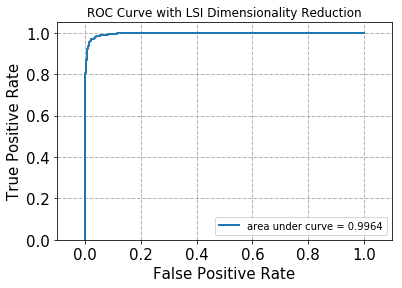

In [0]:
from sklearn.metrics import recall_score, roc_curve, auc

# Calculate fpr and tpr
fpr, tpr, _ = roc_curve(y_test_dataset, y_score[:,1])

# Function to plot ROC curve
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title('ROC Curve with LSI Dimensionality Reduction')

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

# Call function to plot ROC
plot_roc(fpr, tpr)

**Confusion Matrix**

Code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cm = confusion_matrix(y_test_dataset, y_pred)
print('Confusion Matrix for Logistic Regression Classifier')
print(cm)

Confusion Matrix for Logistic Regression Classifier
[[1505   55]
 [  37 1553]]


**Accuracy, Recall, Precision, and F-1 Score**

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Calculate accuracy
print("Accuracy: {:.3f}".format(accuracy_score(y_test_dataset, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test_dataset, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test_dataset, y_pred)))
print("F-1 Score: {:.3f}".format(f1_score(y_test_dataset, y_pred)))

Accuracy: 0.971
Recall: 0.977
Precision: 0.966
F-1 Score: 0.971


### Logistic Regression with Regularization
  * Using 5-fold cross-validation on the dimension-reduced-by-svd training data, find the best regularization strength in the range ... for logistic regression with L1 regularization and logistic regression L2 regularization, respectively.
  * Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.
  * How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?
  * Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary? Why their performance differ?

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
import math

# Define parameter(s) to be used in the grid search
parameters = {'C': [math.pow(10,k) for k in range(-3,4)]}

# Create a grid search to find the best C value for L1 Penalty
grid_clf_l1 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), 
                        parameters, cv=5)
grid_clf_l1.fit(X_transformed_train, y_train_dataset)

print("Best Inverse Regularization strength for L1 Penalty: ")
print(grid_clf_l1.best_params_)

# Create a grid search to find the best C value for L1 Penalty
grid_clf_l2 = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', 
                                           max_iter=200), parameters, cv=5)
grid_clf_l2.fit(X_transformed_train, y_train_dataset)

print("Best Inverse Regularization strength for L2 Penalty: ")
print(grid_clf_l2.best_params_)

Best Inverse Regularization strength for L1 Penalty: 
{'C': 10.0}
Best Inverse Regularization strength for L2 Penalty: 
{'C': 100.0}


* Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

In [0]:
# Performance of Logistic Regression with L1 penalty and C=10 on test data
classifier = LogisticRegression(penalty='l1', C=10, solver='liblinear')
classifier.fit(X_transformed_train, y_train_dataset)
y_pred = classifier.predict(X_transformed_test)

print("\nLogistic Regression with L1 Penalty and C=10")
print("Accuracy: {:.3f}".format(accuracy_score(y_test_dataset, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test_dataset, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test_dataset, y_pred)))
print("F-1 Score: {:.3f}".format(f1_score(y_test_dataset, y_pred)))

# Performance of Logistic Regression with L2 penalty and C=100 on test data
classifier = LogisticRegression(penalty='l2', C=100, solver='lbfgs')
classifier.fit(X_transformed_train, y_train_dataset)
y_pred = classifier.predict(X_transformed_test)

print("\nLogistic Regression with L2 Penalty and C=100")
print("Accuracy: {:.3f}".format(accuracy_score(y_test_dataset, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test_dataset, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test_dataset, y_pred)))
print("F-1 Score: {:.3f}".format(f1_score(y_test_dataset, y_pred)))


Logistic Regression with L1 Penalty and C=10
Accuracy: 0.972
Recall: 0.979
Precision: 0.966
F-1 Score: 0.973

Logistic Regression with L2 Penalty and C=100
Accuracy: 0.972
Recall: 0.979
Precision: 0.966
F-1 Score: 0.973


##Question 6: Naive Bayes (Danny)



In [0]:
# Combine sub-classes of docs into 'Computer Technology' and 'Recreational
# Activity' using floor division such that when target is less than 4, it
# becomes 0 and when it's between 4 and 7, it becomes 1
vfunc = np.vectorize(lambda target: target // 4)
y_train_dataset = vfunc(train_dataset.target)
y_test_dataset = vfunc(test_dataset.target)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_transformed, y_train_dataset)
y_pred = gnb.predict(X_test_transformed)
y_score = gnb.predict_proba(X_test_transformed)

"""**Calculate ROC Curve**

Use roc_curve from sklearn
"""

from sklearn.metrics import roc_curve, auc

# Calculate false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test_dataset, y_score[:,1])

# Call function to plot ROC
plot_roc(fpr, tpr)
plt.show()

"""**Confusion Matrix**

Code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_dataset, y_pred)
print('Confusion Matrix for GaussianNB Classifier')
print(cm)

"""**Accuracy, Recall, Precision, and F-1 Score**"""

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Calculate accuracy
print("Accuracy: {:.3f}".format(accuracy_score(y_test_dataset, y_pred)))
print("Recall: {:.3f}".format(recall_score(y_test_dataset, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test_dataset, y_pred)))
print("F-1 Score: {:.3f}".format(f1_score(y_test_dataset, y_pred)))


##Question 7: Grid Search of Parameters

# Best Param for Data w/ headers and footers and w/o analyzer
{'clf': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False), 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 'vect__min_df': 3}


# Best Param for Data w/o headers and footers and w/o analyzer
{'clf': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False), 
          'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
          random_state=None, tol=0.0), 
          'vect__min_df': 5}


In [0]:
from sklearn.pipeline import Pipeline
import sys
sys.setrecursionlimit(100000)
from IPython.display import display
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
import pandas as pd
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin

class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

#analyzer = stem_remove_punc
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 
              'rec.sport.hockey']
train_set = fetch_20newsgroups(subset='train', remove=('headers', 'footers'),
                              categories=categories)
test_set = fetch_20newsgroups(subset='train', remove=('headers', 'footers'),
                             categories=categories)

pipeline = Pipeline([
    ('vect', text.CountVectorizer(min_df=3, stop_words='english',
                             analyzer=stem_remove_punc
                                 )),
    ('tfidf', text.TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    #('toarr', SparseToDenseArray()),
    ('clf', SVC())
]
    ,
    memory=memory
)

param_grid = [
    {
        #'vect': [text.CountVectorizer(stop_words='english')],
        #'vect__analyzer': ['word', lemmatize],
        'vect__min_df': [3,5],
        'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
        'clf': [SVC(C=100, kernel='linear'), 
                LogisticRegression(penalty='l1', C=10, solver='liblinear'),
                LogisticRegression(penalty='l2', C=100, solver='lbfgs')]
    },
    {
        #'vect': [text.CountVectorizer(stop_words='english')],
        #'vect__analyzer': ['word', lemmatize],
        'vect__min_df': [3, 5],
        'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
        'clf': [GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, 
                    scoring='accuracy', verbose=0)

# Training data without headers and footers
grid.fit(train_set.data, y_train_dataset)
result1 = pd.DataFrame(grid.cv_results_)
display(result1)

# Training data with headers and footers
grid.fit(train_dataset.data, y_train_dataset)
result2 = pd.DataFrame(grid.cv_results_)
display(result2)

rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_remove_punc at 0x7fdc833ab2f0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
[ 'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob',
  'I used HP DeskJet with Orange Micros Grappler LS on System6.0.5.\n'
  '\n'
  'But now I update system 6.0.5 to System7 with Kanji-Talk 7.1,\n'
  'then I can not print by my DeskJet.\n'
  '\n'
  'Is the Grappler LS old ?\n'
  'Can I use DeskJet on System7 ?\n'
  '\n'
  'Please tell me how to use Desk

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.96s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 85.4s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11709 sparse matrix of type '<class 'numpy.int64'>'
	with 210469 stored elements in Compressed Sparse Row format>, 
array([0, ..., 0]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x11709 sparse matrix of type '<class 'numpy.float64'>'
	with 210469 stored elements in Compressed Sparse Row format>, 
array([0, ..., 0]), None)
_______________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 81.7s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11320 sparse matrix of type '<class 'numpy.int64'>'
	with 206599 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x11320 sparse matrix of type '<class 'numpy.float64'>'
	with 206599 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None)
_______________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 84.9s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11888 sparse matrix of type '<class 'numpy.int64'>'
	with 211016 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0), 
<3785x11888 sparse matrix of type '<class 'numpy.float64'>'
	with 211016 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None)
_______________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:230: UserWarning: Persisting input arguments took 2.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
